In [13]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
from codac.datastore import client
import sys
import os
import glob
sys.path.append('/home/jleland/Coding/Projects/flopter')
from magopter import Magopter
import fitters as f
import classes.ivdata as iv
from scipy.interpolate import interp1d

In [2]:
folders = ['2018-05-01_Leland/', '2018-05-02_Leland/', '2018-05-03_Leland/',
               '2018-06-05_Leland/', '2018-06-06_Leland/', '2018-06-07_Leland/']
files = []
file_folders = []
for folder1 in folders:
    os.chdir(Magopter.get_data_path() + folder1)
    files.extend(glob.glob('*.adc'))
    file_folders.extend([folder1] * len(glob.glob('*.adc')))

files.sort()

file = files[-2]
ts_file = files[-1]
folder = file_folders[-2]
print([folder, file])
print([folder, ts_file]) 

['2018-06-07_Leland/', '2018-06-07 14h 38m 33s TT_06564321037878221702.adc']
['2018-06-07_Leland/', '2018-06-07_14h_33m_45s_TT_06564319866763108260.adc']


In [3]:
mago = Magopter(folder, ts_file)

down_sampling_rate = 10
arr_size = len(mago.m_data.data[mago.m_data.channels[0]])
downsample = np.arange(0, arr_size, down_sampling_rate, dtype=np.int64)

for ch, data in mago.m_data.data.items():
    mago.m_data.data[ch] = data[downsample]
mago.m_data.time = mago.m_data.time[downsample] + mago._ADC_TIMER_OFFSET

mago.m_data.data[mago._VOLTAGE_CHANNEL] = mago.m_data.data[mago._VOLTAGE_CHANNEL] * 10

# Find region of interest
frequency = 20
start = 102000
end = 115500

# start = 10000
# end = 360000
start = 0
end = len(mago.m_data.time)

segmentation = np.linspace(start, end, 2, dtype=np.int64)

mago.iv_arr_coax_0 = []
mago.iv_arr_coax_1 = []

for j in range(len(segmentation) - 1):
    # TODO: Improve the peak finding algorithm
    seg_start = segmentation[j]
    seg_end = segmentation[j+1]

    # Fit and find peaks of voltage triangle wave
    raw_time = mago.m_data.time[seg_start:seg_end]
    raw_voltage = mago.m_data.data[mago._VOLTAGE_CHANNEL][seg_start:seg_end]
    raw_current_0 = mago.m_data.data[mago._PROBE_CHANNEL_3][seg_start:seg_end]
    raw_current_1 = mago.m_data.data[mago._PROBE_CHANNEL_4][seg_start:seg_end]
    
    # smoothed_voltage = sig.savgol_filter(raw_voltage, 21, 2)
    top = sig.argrelmax(raw_voltage, order=20)[0]
    bottom = sig.argrelmin(raw_voltage, order=20)[0]
    # top = sig.argrelmax(triangle_fit.fit_y, order=20)[0]
    # bottom = sig.argrelmin(triangle_fit.fit_y, order=20)[0]

    print(raw_time[np.min([bottom[0], top[0]])], raw_time[-1], 1/(2 * frequency))
    mago.peaks = np.arange(raw_time[np.max([bottom[0], top[0]])], raw_time[-1], 1/(2 * frequency))
    # mago.peaks = raw_time[np.sort(np.concatenate([top, bottom], 0))]

    

Ice.ConnectionRefusedException:
Connection refused
Database could not be connected to, operating in offline mode.
1.0011000022 5.99990999982 0.025


Threshold = 0.024
Threshold = 0.048
[ 5.96840994  1.0021      2.54340309]


<IPython.core.display.Javascript object>


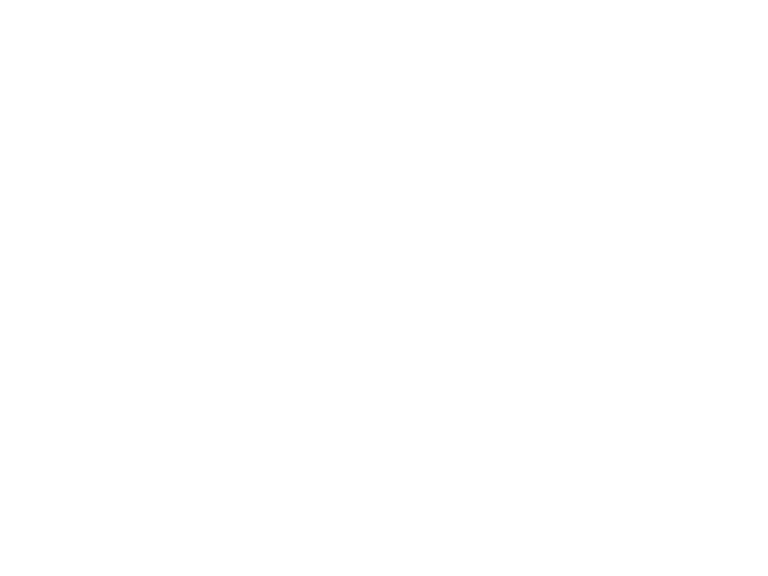

<IPython.core.display.Javascript object>


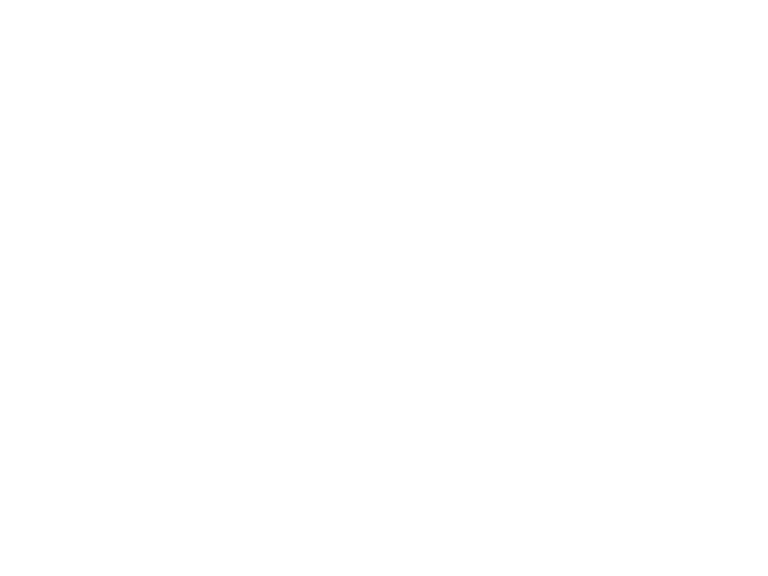

(0.95, 1.25)

In [4]:
# Playground for imrpoving the peak finding algorithm

# ceiling = [1.2, 1.5]
ceiling = [0.95, 1.25]
THRESHOLD = 0.2

sm = sig.savgol_filter(raw_voltage, 21, 2)
sm_grad = np.gradient(sm)
# sm_grad = np.gradient(raw_voltage)
abs_sm_grad = np.abs(sm_grad)
pks = raw_time[sig.argrelmin(abs_sm_grad, order=100)[0]]
pks3 = raw_time[np.where(abs_sm_grad < THRESHOLD)]

pks2 = raw_time[np.concatenate([sig.argrelmax(sm, order=100)[0], sig.argrelmin(sm, order=100)[0]])] 
pks4 = raw_time[sig.argrelmax(sm, order=100)[0]]

peaks = []
# for i, difference in enumerate(np.diff(pks3)):
#     if difference > (1/frequency) - 0.001:
#         peaks.append(pks3[i])
threshold = (1/(2*frequency)) - 0.001
print('Threshold = {}'.format(threshold))
for i in range(len(pks2) - 2):
    if (pks2[i] - pks2[i-1]) > threshold and (pks2[i+1] - pks2[i]) > threshold:
        peaks.append(pks2[i])
peaks.sort()

peaks2 = []
threshold = (1/frequency) - 0.002
print('Threshold = {}'.format(threshold))
for i in range(len(pks4) - 2):
    if (pks4[i] - pks4[i-1]) > threshold and (pks4[i+1] - pks4[i]) > threshold:
        peaks2.append(pks4[i])
        
print(pks2[np.where(np.diff(pks2) < (1 / frequency) - 0.002)])
# pks2_l = raw_time[]
# pks2 = extend()
pks2.sort()

plt.figure()
# plt.plot(raw_time, sm_grad)
plt.plot(raw_time, np.abs(sm_grad))
# for pk in pks:
#     plt.axvline(x=pk, linestyle='dashed', linewidth=1, color='r')
# for pk in pks2:
#     plt.axvline(x=pk, linestyle='dashed', linewidth=1, color='k')
for pk in pks3:
    plt.axvline(x=pk, linestyle='dashed', linewidth=1, color='m')
for pk in peaks:
    plt.axvline(x=pk, linestyle='dashed', linewidth=1, color='k')
plt.xlim(ceiling)
plt.ylim([-1, 1])

plt.figure()
plt.plot(raw_time, raw_voltage)
# for pk in pks:
#     plt.axvline(x=pk, linestyle='dashed', linewidth=1, color='r')
# for pk in pks2:
#     plt.axvline(x=pk, linestyle='dashed', linewidth=1, color='k')
# for pk in pks2:
#     plt.axvline(x=pk, linestyle='dashed', linewidth=1, color='m')
# for pk in peaks2:
#     plt.axvline(x=pk, linestyle='dashed', linewidth=1, color='k')
for peak in mago.peaks:
    plt.axvline(x=peak, linestyle='dashed', linewidth=1, color='g')
plt.xlim(ceiling)

1.0183000366


<IPython.core.display.Javascript object>


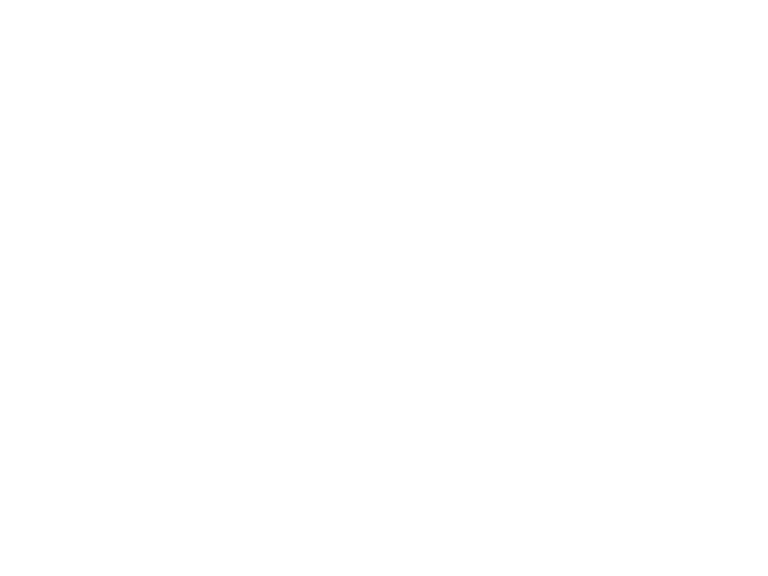

(0.95, 1.25)

In [5]:
sm = sig.savgol_filter(raw_voltage, 21, 2)
sm_grad = np.gradient(sm)
abs_sm_grad = np.abs(sm_grad)

pks = raw_time[np.concatenate([sig.argrelmax(sm, order=100)[0], sig.argrelmin(sm, order=100)[0]])]
pks.sort()
pk_dist = np.diff(pks)

threshold = (1/(2*frequency)) - 0.001
w = np.where(pk_dist > threshold)[0]
print(pks[w[0]])

pks_refined = np.arange(pks[w[0]], raw_time[-1], 1/(2 * frequency))

plt.figure()
plt.plot(raw_time, raw_voltage)
for pk in pks[w]:
    plt.axvline(x=pk, linestyle='dashed', linewidth=1, color='r')
for pk in pks_refined:
    plt.axvline(x=pk, linewidth=1, color='k')
# for peak in mago.peaks:
#     plt.axvline(x=peak, linestyle='dashed', linewidth=1, color='g')
plt.xlim(ceiling)

<IPython.core.display.Javascript object>


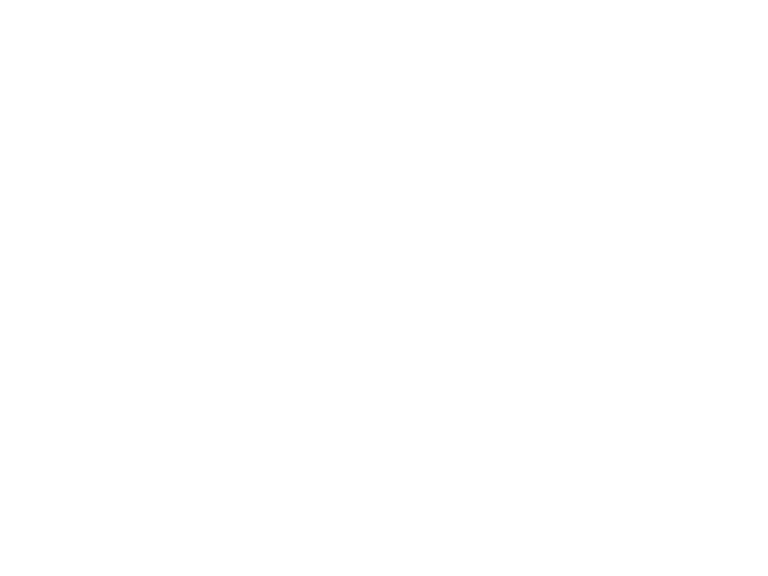

[[Model]]
    Model(triangle_wave)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 50000
    # variables        = 4
    chi-square         = 186807.842
    reduced chi-square = 3.73645576
    Akaike info crit   = 65910.8751
    Bayesian info crit = 65946.1542
[[Variables]]
    a:   -50.0409788 +/- 0.01497301 (0.03%) (init = 50)
    p:    0.05000026 +/- 7.4804e-08 (0.00%) (init = 0.05)
    y_0: -46.2214281 +/- 0.00864467 (0.02%) (init = -45)
    x_0:  0.13260702 +/- 1.1328e-04 (0.09%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(p, x_0) =  0.924



<IPython.core.display.Javascript object>


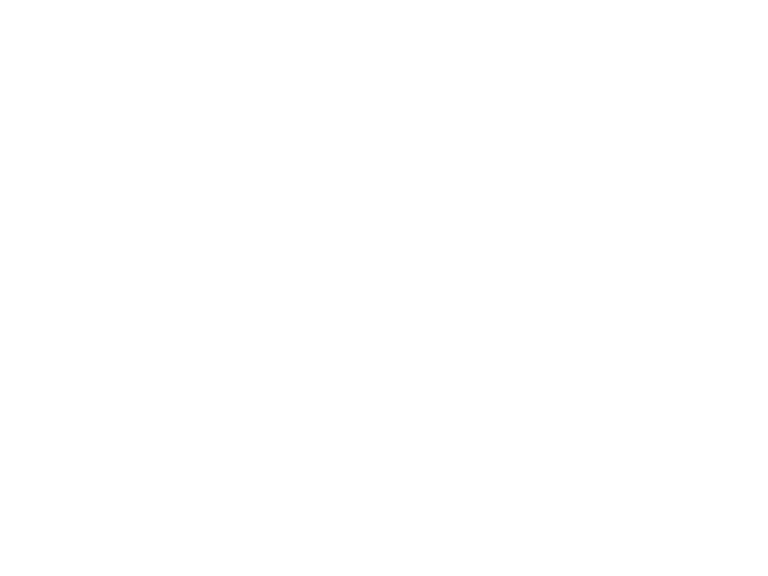

In [6]:
import lmfit as lm

temp_time = raw_time
temp_volt = raw_voltage
def triangle_wave(v, a, p, y_0, x_0):
    return (((4 * a) / p) * (np.abs(np.mod(v + (x_0 * p), p) - (p / 2)) - (p / 4))) + y_0

tmodel = lm.Model(triangle_wave)
result = tmodel.fit(temp_volt, v=temp_time, a=50, p=0.05, y_0=-45, x_0=0)

tfitter = f.TriangleWaveFitter()
tfit_data = tfitter.fit(temp_time, temp_volt, initial_vals=[0.05, 50, -45, 0], calc_guess_fl=False)
tfit_data.plot()

print(result.fit_report())

plt.figure()
plt.plot(temp_time, temp_volt, 'x')
plt.plot(temp_time, result.init_fit, 'k--')
plt.plot(temp_time, result.best_fit, 'r-')


<IPython.core.display.Javascript object>


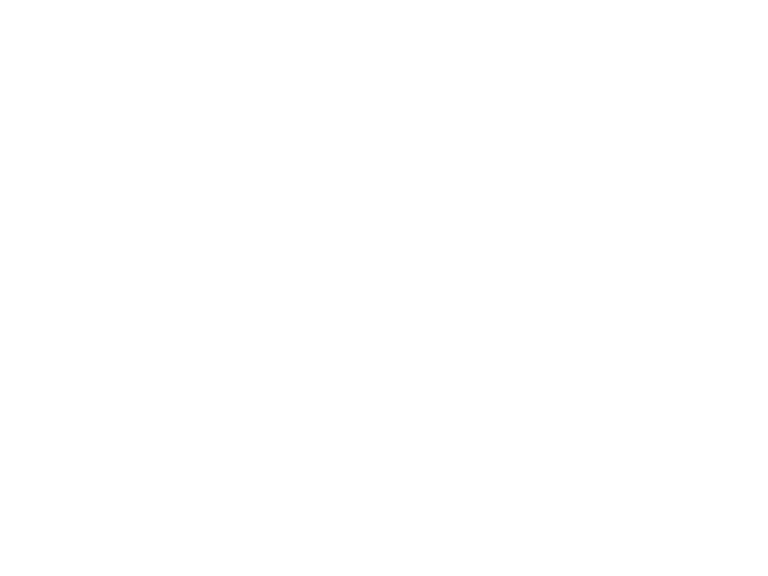

In [7]:
mago.peaks = peaks

straight_line = f.StraightLineFitter()
triangle = f.TriangleWaveFitter()
for i in range(len(mago.peaks) - 1):
    sweep_start = np.abs(raw_time - mago.peaks[i]).argmin()
    sweep_stop = np.abs(raw_time - mago.peaks[i+1]).argmin()
    # sweep_stop = mago.peaks[i + 1]
    sweep_voltage = raw_voltage[sweep_start:sweep_stop]
    # sweep_fit = triangle_fit.fit_y[sweep_start:sweep_stop]
    sweep_time = raw_time[sweep_start:sweep_stop]
    sweep_fit = straight_line.fit(sweep_time, sweep_voltage)
#     sweep_fit = triangle.fit(sweep_time, sweep_voltage, freq=frequency, calc_guess_fl=False)
    if i == 0:
        sweep_fit.plot()
    mago.max_voltage.append((np.max(np.abs(sweep_voltage - sweep_fit.fit_y))))

    if np.max(np.abs(sweep_voltage - sweep_fit.fit_y)) > mago._ARCING_THRESHOLD:
        mago.arcs.append(np.mean(sweep_time))
        continue

    sweep_current_0 = raw_current_0[sweep_start:sweep_stop]
    sweep_current_1 = raw_current_1[sweep_start:sweep_stop]
    if sweep_voltage[0] > sweep_voltage[-1]:
        sweep_voltage = np.array(list(reversed(sweep_voltage)))
        sweep_time = np.array(list(reversed(sweep_time)))
        sweep_current_0 = np.array(list(reversed(sweep_current_0)))
        sweep_current_1 = np.array(list(reversed(sweep_current_1)))
    mago.iv_arr_coax_0.append(iv.IVData(np.array(sweep_voltage) - np.array(sweep_current_0),
                                        sweep_current_0, sweep_time))
    mago.iv_arr_coax_1.append(iv.IVData(np.array(sweep_voltage) - np.array(sweep_current_1),
                                        sweep_current_1, sweep_time))

mago.iv_arrs = [
    mago.iv_arr_coax_0,
    mago.iv_arr_coax_1
]

<IPython.core.display.Javascript object>


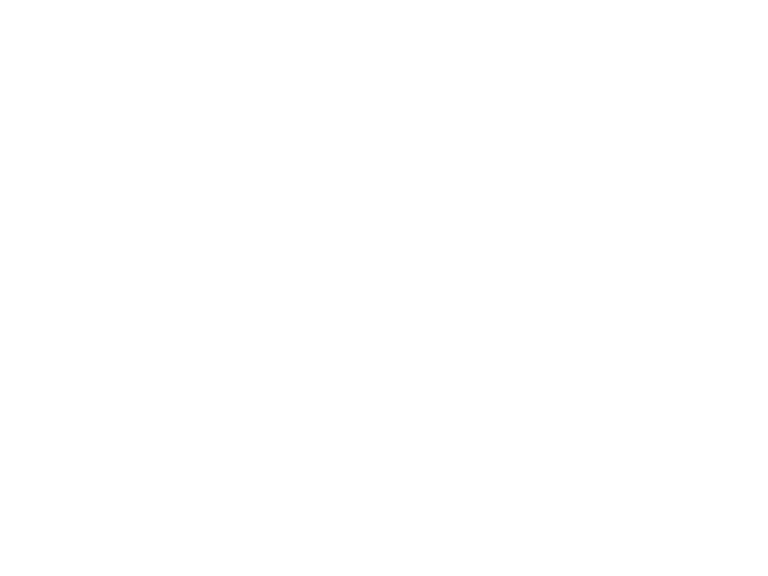

AttributeError: 'IVData' object has no attribute 'time'

In [8]:
fig, ax = plt.subplots()
max_currents = [[], []]
for iv_curve in mago.iv_arr_coax_0:
    plt.plot(iv_curve.time, -iv_curve.current)
    plt.plot(iv_curve.time, iv_curve.voltage)
    max_current = np.max(iv_curve.current)
    max_currents[1].append(np.max(iv_curve.current))
    max_currents[0].append(iv_curve.time[list(iv_curve.current).index(max_current)])

<IPython.core.display.Javascript object>


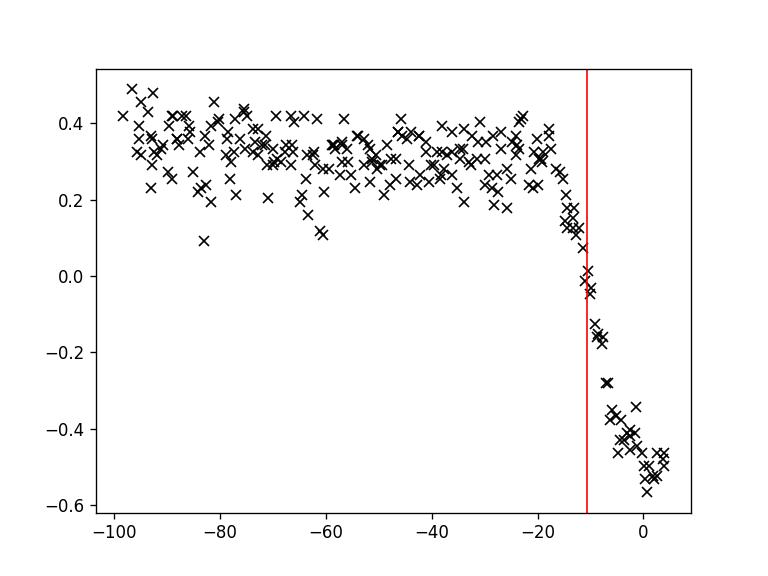

-10.40180082
-83.1148555696


<IPython.core.display.Javascript object>


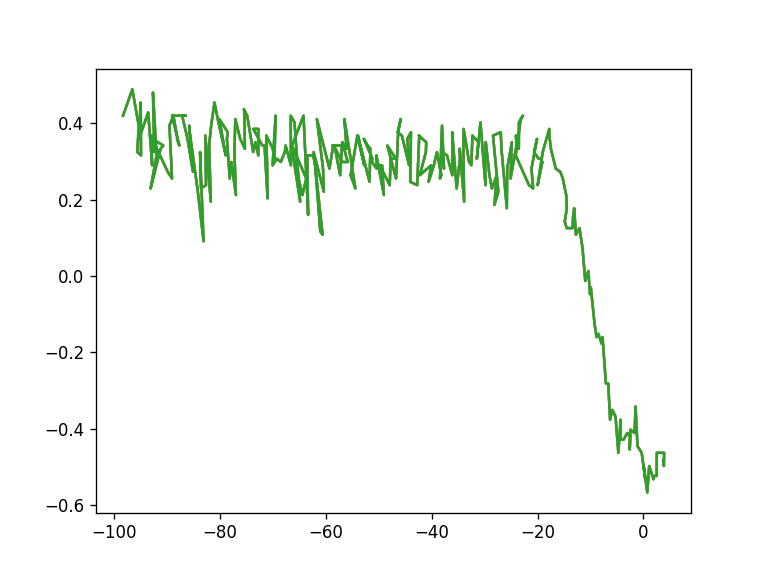

In [12]:
iv_datas = mago.iv_arr_coax_0[20:23]

iv_data = iv_datas[0]

plt.figure()
plt.plot(*iv_data.split(), 'kx')
v_f = f.IVFitter.find_floating_pot(iv_data)

# iv_interp = interp1d(iv_data.current, iv_data.voltage)
# v_f_alt = iv_interp([0.0])
# print(v_f_alt)

v_f_alt2 = iv_data['V'][np.abs(iv_data['I'] - 0).argmin()]
print(v_f_alt2)

plt.axvline(x=v_f, color='r', linestyle='-', linewidth='1')


str_sec = np.where(iv_data['V'] <= -30)
v_ss = iv_data['V'][str_sec]
i_ss = iv_data['I'][str_sec]

v_f_alt2 = v_ss[np.abs(i_ss - 0).argmin()]
print(v_f_alt2)

siv_f = f.StraightIVFitter(floating_potential=v_f)
siv_f_data = siv_f.fit(v_ss, i_ss)
I_sat_guess = siv_f_data.get_isat().value

fitter = f.FullIVFixedISatFitter(I_sat_guess, floating_potential=v_f)

plt.figure()
# plt.plot(*iv_data.split(), 'kx')
for end in [0.8, 0.85, 0.9]:
    iv_data_trim = iv.trim(iv_data, trim_end=end)
    plt.plot(*iv_data_trim.split())
    first_fit_data = fitter.fit_iv_data(iv_data_trim)
#     plt.plot(*first_fit_data.get_fit_plottables(), '--')




# plt.figure()


# plt.axvline(x=v_f, color='k', linestyle='-', linewidth='1')
